# Load Audio Data 

In [1]:
import os

def load_dataset(root_folder):
    # Initializes dictionary (audio_files) to store paths to {train, test}
    audio_files = {'train': [], 'test': []}
      
    # List of supported audio file extensions
    supported_extensions = ['.WAV', '.WAV.wav', '.mp3', '.flac']
    
    train_folder = os.path.join(root_folder, 'TRAIN')  # data/TRAIN
    test_folder = os.path.join(root_folder, 'TEST')    # data/TEST
    
    for folder in [train_folder, test_folder]:
        subset = 'train' if 'TRAIN' in folder else 'test'
        # Iterate through each DR
        for DR in os.listdir(folder):
            DR_folder = os.path.join(folder, DR)  # ex: data/TRAIN/DR1
            if os.path.isdir(DR_folder):
                for speaker in os.listdir(DR_folder):
                    speaker_folder = os.path.join(DR_folder, speaker)  # ex: data/TRAIN/DR1/FCJF0
                    if os.path.isdir(speaker_folder):
                        # List speaker_folder Directory (ex: ['SA1.WAV', 'SA1.WAV.wav', 'SA2.WAV', ...])
                        for file in os.listdir(speaker_folder):
                            if any(file.endswith(ext) for ext in supported_extensions):
                                file_path = os.path.join(speaker_folder, file)  # ex: data/TRAIN/DR1/FCJF0/SA1.WAV
                                audio_files[subset].append(file_path)
                                
    return audio_files

audio_files = load_dataset(r"Dataset\data")

print(f"Number of training audio files: {len(audio_files['train'])}")
print(f"Number of testing audio files: {len(audio_files['test'])}")


Number of training audio files: 9240
Number of testing audio files: 3360


C:\Users\asalk\AppData\Local\Temp\ipykernel_10244\3913541402.py:15: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y, sr=sr, x_axis='time')


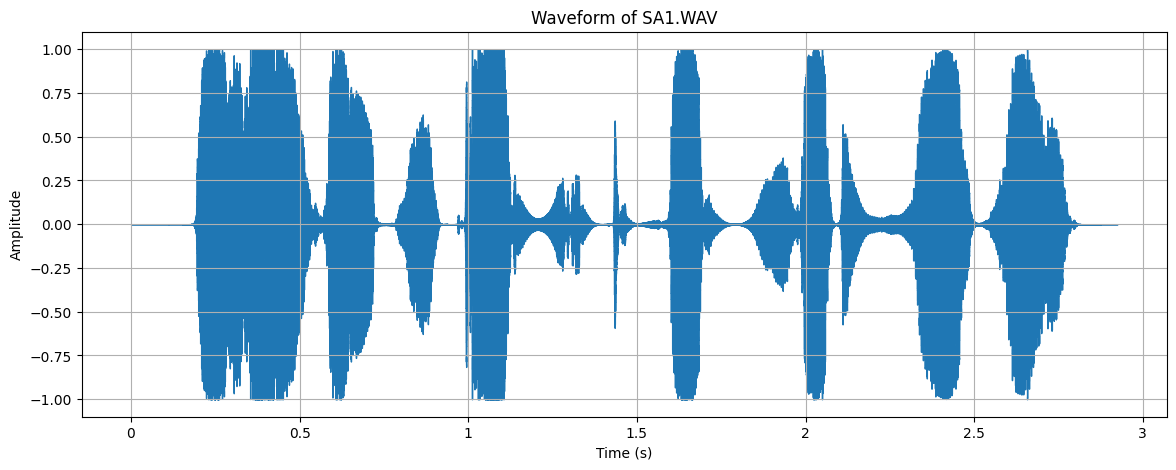

In [2]:
#Visualize for Data before preprocessing
import matplotlib.pyplot as plt
import librosa
import librosa.display

def visualize_audio(file_path):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Create a time variable for x-axis
    times = librosa.times_like(y, sr=sr)
    
    # Plot the waveform
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr, x_axis='time')
    plt.title(f'Waveform of {os.path.basename(file_path)}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

    
example_file = audio_files['train'][0]  
visualize_audio(example_file)

# Preprocessing

## Audio Files

### 1.Consistent Format Conversion & Resampling

In [3]:
import soundfile as sf
import librosa

# Convert to consistent format
def convert_to_consistent_format(audio_files):
    converted_count = {'train': 0, 'test': 0}
    already_16kHz_Wav = {'train': 0, 'test': 0}
    
    for subset in audio_files:
        for filepath in audio_files[subset]:
            data, samplerate = sf.read(filepath)
            if samplerate != 16000:
                data_16k = librosa.resample(data, orig_sr=samplerate, target_sr=16000)
                sf.write(filepath, data_16k, 16000)
                converted_count[subset] += 1
            else:
                already_16kHz_Wav[subset]+= 1
  
    
    print("Conversion to 16kHz WAV format completed.")
    print(f"Number of training audio files converted: {converted_count['train']}")
    print(f"Number of testing audio files converted: {converted_count['test']}")
    print(f"Number of training audio files already_16kHz_Wav: {already_16kHz_Wav['train']}")
    print(f"Number of testing audio files already_16kHz_Wav: {already_16kHz_Wav['test']}")

# Call the function
convert_to_consistent_format(audio_files)


Conversion to 16kHz WAV format completed.
Number of training audio files converted: 0
Number of testing audio files converted: 0
Number of training audio files already_16kHz_Wav: 9240
Number of testing audio files already_16kHz_Wav: 3360


### 2. Normalization
Normalize the audio: The apply_gain method is used to adjust the volume of the audio segment so that its maximum volume reaches 0 dBFS (decibels relative to full scale).

dBFS (Decibels relative to Full Scale): This is a measure of amplitude levels in digital audio. 0 dBFS represents the maximum possible digital level without clipping (distortion). By normalizing to 0 dBFS, you ensure that the loudest part of the audio reaches this maximum level without distortion, making the audio uniformly loud.

In [4]:
from pydub import AudioSegment
import numpy as np
import soundfile as sf
from concurrent.futures import ThreadPoolExecutor, as_completed

def Normalize_file(filepath):
    try:
        # Read the audio file
        audio_segment = AudioSegment.from_file(filepath)

        # Normalize the audio
        normalized_audio = audio_segment.apply_gain(-audio_segment.dBFS)

        # Convert the normalized audio back to a numpy array
        normalized_data = np.array(normalized_audio.get_array_of_samples(), dtype=np.int16)

        # Save the processed audio back to file
        sf.write(filepath, normalized_data, normalized_audio.frame_rate, subtype='PCM_16')
        return True
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return False

def normalize_audio(audio_files):
    normalized_count = {'train': 0, 'test': 0}
    with ThreadPoolExecutor(max_workers=5) as executor: 
        future_to_filepath = {executor.submit(Normalize_file, filepath): filepath for subset in audio_files for filepath in audio_files[subset]}
        for future in as_completed(future_to_filepath):
            filepath = future_to_filepath[future]
            if future.result():
                subset = 'train' if 'TRAIN' in filepath else 'test'
                normalized_count[subset] += 1

    print("Normalization completed.")
    print(f"Number of training audio files normalized: {normalized_count['train']}")
    print(f"Number of testing audio files normalized: {normalized_count['test']}")


normalize_audio(audio_files)


C:\Users\asalk\AppData\Roaming\Python\Python312\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Normalization completed.
Number of training audio files normalized: 9240
Number of testing audio files normalized: 3360


### 3.Noise Reduction

In [5]:
import noisereduce as nr
import soundfile as sf
from concurrent.futures import ThreadPoolExecutor, as_completed

def reducenoise_file(filepath):
    try:
        # Read the audio file
        data, samplerate = sf.read(filepath)
        
        # Apply noise reduction
        reduced_noise = nr.reduce_noise(y=data, sr=samplerate)
        
        # Save the processed audio back to file
        sf.write(filepath, reduced_noise, samplerate, subtype='PCM_16')
        return True
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return False

    
def reduce_noise(audio_files):
    reduced_noise_count = {'train': 0, 'test': 0}
  
    with ThreadPoolExecutor(max_workers=4) as executor:  
        future_to_filepath = {executor.submit(reducenoise_file, filepath): filepath for subset in audio_files for filepath in audio_files[subset]}
        for future in as_completed(future_to_filepath):
            filepath = future_to_filepath[future]
            if future.result():
                subset = 'train' if 'TRAIN' in filepath else 'test'
                reduced_noise_count[subset] += 1

    print("Noise Reduction completed.")
    print(f"Number of training audio files reduced: {reduced_noise_count['train']}")
    print(f"Number of testing audio files reduced: {reduced_noise_count['test']}")

# Call the function
audio_files = load_dataset(r"Dataset\data")
reduce_noise(audio_files)

Noise Reduction completed.
Number of training audio files reduced: 9240
Number of testing audio files reduced: 3360


C:\Users\asalk\AppData\Local\Temp\ipykernel_10244\2501733964.py:15: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y, sr=sr, x_axis='time')


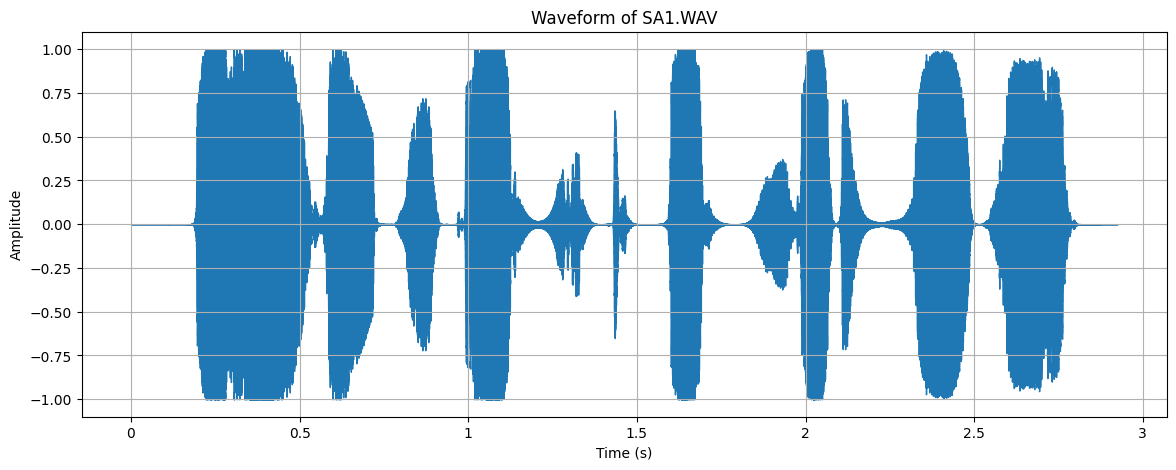

In [6]:
#Visualize for Data after preprocessing
import matplotlib.pyplot as plt
import librosa
import librosa.display

def visualize_audio(file_path):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Create a time variable for x-axis
    times = librosa.times_like(y, sr=sr)
    
    # Plot the waveform
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr, x_axis='time')
    plt.title(f'Waveform of {os.path.basename(file_path)}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

audio_files = load_dataset(r"Dataset\data")
example_file = audio_files['train'][0]  
visualize_audio(example_file)

### 4.Feature Extraction(Log-Mel Spectrogram)
based on whisper feature:

y=audio_files, sr=16000, n_mels=80, hop_length=160(10 millisecond, n_fft=400(25-millisecond window)

In [7]:
import librosa
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

# Converts an audio signal into a log-mel spectrogram.
def compute_logmel_spectrogram(y, sr=16000, n_mels=80, hop_length=160, n_fft=400):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
    logmel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return logmel_spectrogram


def process_file(filepath):
    try:
        y, sr = librosa.load(filepath, sr=16000)
        logmel_spectrogram = compute_logmel_spectrogram(y, sr)
        return logmel_spectrogram
    except Exception as e:
        print(f"Error processing file {filepath}: {e}")
        return None

    
# Function to read audio files in parallel
def read_and_compute_logmel_spectrograms(audio_files, max_workers=4):
    spectrograms = {'train': [], 'test': []}
    for subset in audio_files:
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_filepath = {executor.submit(process_file, filepath): filepath for filepath in audio_files[subset]}
            for future in as_completed(future_to_filepath):
                filepath = future_to_filepath[future]
                try:
                    spectrogram = future.result()
                    if spectrogram is not None:
                        spectrograms[subset].append(spectrogram)
                except Exception as e:
                    print(f"Error processing file {filepath}: {e}")
    
    return spectrograms

# Load the dataset
audio_files = load_dataset(r"Dataset\data")

# Compute the log-mel spectrograms
spectrograms = read_and_compute_logmel_spectrograms(audio_files, max_workers=4)


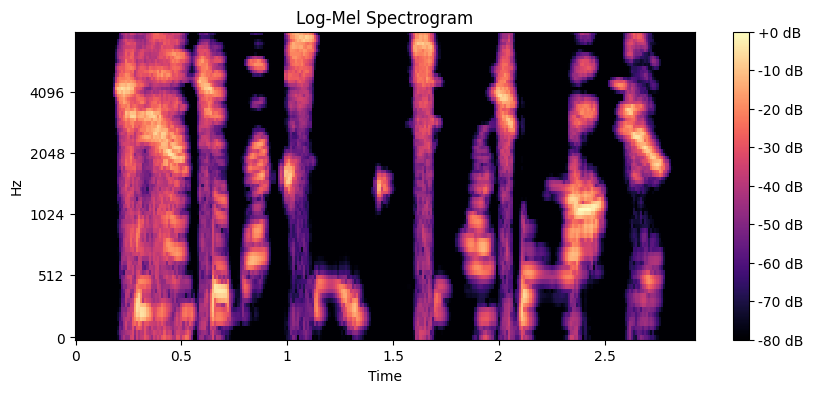

In [13]:
import matplotlib.pyplot as plt

def plot_logmel_spectrogram(logmel_spectrogram, sr=16000, hop_length=160):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(logmel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-Mel Spectrogram')
    plt.show()

# Example usage:
example_filepath = r"Dataset\data\TRAIN\DR1\FCJF0\SA1.WAV"
y, sr = librosa.load(example_filepath, sr=16000)
logmel_spectrogram = compute_logmel_spectrogram(y, sr)
plot_logmel_spectrogram(logmel_spectrogram, sr)


## Text Files (Transcription)

# Load Text Data
Half of Audio Data

In [1]:
import os
import shutil

def load_dataset(root_folder):
    # Initializes dictionary (audio_files) to store paths to {train, test}
    Text_files = {'train': [], 'test': []}
          
    train_folder = os.path.join(root_folder, 'TRAIN')  # data/TRAIN
    test_folder = os.path.join(root_folder, 'TEST')    # data/TEST
    
    for folder in [train_folder, test_folder]:
        subset = 'train' if 'TRAIN' in folder else 'test'
        # Iterate through each DR
        for DR in os.listdir(folder):
            DR_folder = os.path.join(folder, DR)  # ex: data/TRAIN/DR1
            if os.path.isdir(DR_folder):
                for Text in os.listdir(DR_folder):
                    Text_folder = os.path.join(DR_folder, Text)  # ex: data/TRAIN/DR1/FCJF0
                    if os.path.isdir(Text_folder):
                        # List Text_folder Directory (ex: ['SA1.TXT', ...])
                        for file in os.listdir(Text_folder):
                            if file.endswith('.TXT'):
                                file_path = os.path.join(Text_folder, file)  # ex: data/TRAIN/DR1/FCJF0/SA1.TXT
                                Text_files[subset].append(file_path)
                                
    return Text_files


def save_txt_files(Text_files, destination_folder):
    for subset, files in Text_files.items():
        for file_path in files:
            relative_path = os.path.relpath(file_path, start=os.path.join(root_folder, subset.upper()))
            dest_path = os.path.join(destination_folder, subset.upper(), relative_path)
            dest_dir = os.path.dirname(dest_path)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copy(file_path, dest_path)

root_folder = r"Dataset\data"
destination_folder = r"Dataset\TextFiles"

Text_files = load_dataset(root_folder)

print(f"Number of training Text files: {len(Text_files['train'])}")
print(f"Number of testing Text files: {len(Text_files['test'])}")

save_txt_files(Text_files, destination_folder)


Number of training Text files: 4620
Number of testing Text files: 1680


In [2]:
def print_text_files(text_files):
    for subset in ['train', 'test']:
        print(f"Contents of {subset} Text files:")
        for file_path in text_files[subset]:
            with open(file_path, 'r') as file:
                print(file.read())
        print("\n")
# Print contents of text files
print_text_files(Text_files)        

Contents of train Text files:
0 46797 She had your dark suit in greasy wash water all year.

0 34509 Don't ask me to carry an oily rag like that.

0 49460 Even then, if she took one step forward he could catch her.

0 45466 Or borrow some money from someone and go home by bus?

0 57856 A sailboat may have a bone in her teeth one minute and lie becalmed the next.

0 24679 The emperor had a mean temper.

0 27751 How permanent are their records?

0 23143 The meeting is now adjourned.

0 36250 Critical equipment needs proper maintenance.

0 39220 Tim takes Sheila to see movies twice a week.

0 53556 She had your dark suit in greasy wash water all year.

0 42804 Don't ask me to carry an oily rag like that.

0 77824 This has been attributed to helium film flow in the vapor pressure thermometer.

0 40653 Receiving no answer, they set the fire.

0 76698 As his feet slowed, he felt ashamed of the panic and resolved to make a stand.

0 42087 Cyclical programs will never compile.

0 40141 Clear p

## Preprocessing

### 1.Text Cleaning 

In [3]:
import os
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Normalize text
    return text.strip()

def load_dataset_from_destination(destination_folder):
    # Initializes dictionary (audio_files) to store paths to {train, test}
    Text_files = {'train': [], 'test': []}
    
    for subset in ['TRAIN', 'TEST']:
        subset_folder = os.path.join(destination_folder, subset)
        if os.path.isdir(subset_folder):
            # Iterate through each DR
            for DR in os.listdir(subset_folder):
                DR_folder = os.path.join(subset_folder, DR)  # ex: destination_folder/TRAIN/DR1
                if os.path.isdir(DR_folder):
                    for Text in os.listdir(DR_folder):
                        Text_folder = os.path.join(DR_folder, Text)  # ex: destination_folder/TRAIN/DR1/FCJF0
                        if os.path.isdir(Text_folder):
                            # List Text_folder Directory (ex: ['SA1.TXT', ...])
                            for file in os.listdir(Text_folder):
                                if file.endswith('.TXT'):
                                    file_path = os.path.join(Text_folder, file)  # ex: destination_folder/TRAIN/DR1/FCJF0/SA1.TXT
                                    Text_files[subset.lower()].append(file_path)
                                    
    return Text_files

def save_cleaned_text_files(text_files):
    for subset, files in text_files.items():
        for file_path in files:
            with open(file_path, 'r') as file:
                content = file.read()
                cleaned_content = clean_text(content)
                
            with open(file_path, 'w') as file:
                file.write(cleaned_content)

def print_cleaned_text_files(text_files):
    for subset in ['train', 'test']:
        print(f"Cleaned contents of {subset} Text files:")
        for file_path in text_files[subset]:
            with open(file_path, 'r') as file:
                content = file.read()
                cleaned_content = clean_text(content)
                print(f"File: {cleaned_content}\n")
        print("\n")

# Example:
destination_folder = r"Dataset\TextFiles"

text_files = load_dataset_from_destination(destination_folder)

print_cleaned_text_files(text_files) 

save_cleaned_text_files(text_files)  


Cleaned contents of train Text files:
File: 0 46797 she had your dark suit in greasy wash water all year

File: 0 34509 dont ask me to carry an oily rag like that

File: 0 49460 even then if she took one step forward he could catch her

File: 0 45466 or borrow some money from someone and go home by bus

File: 0 57856 a sailboat may have a bone in her teeth one minute and lie becalmed the next

File: 0 24679 the emperor had a mean temper

File: 0 27751 how permanent are their records

File: 0 23143 the meeting is now adjourned

File: 0 36250 critical equipment needs proper maintenance

File: 0 39220 tim takes sheila to see movies twice a week

File: 0 53556 she had your dark suit in greasy wash water all year

File: 0 42804 dont ask me to carry an oily rag like that

File: 0 77824 this has been attributed to helium film flow in the vapor pressure thermometer

File: 0 40653 receiving no answer they set the fire

File: 0 76698 as his feet slowed he felt ashamed of the panic and resolved t

File: 0 47412 dont ask me to carry an oily rag like that

File: 0 44954 when suitably lighted what would it look like

File: 0 40346 all are well written and are overwritten

File: 0 80487 it was applied with a compost shredder made from a converted manure spreader

File: 0 30618 he stole a dime from a beggar

File: 0 52429 before thursdays exam review every formula

File: 0 34202 they enjoy it when i audition

File: 0 52122 jeff thought you argued in favor of a centrifuge purchase

File: 0 37684 john cleans shellfish for a living

File: 0 45671 she had your dark suit in greasy wash water all year

File: 0 44749 dont ask me to carry an oily rag like that

File: 0 74138 princes and factions clashed in the open street and died on the open scaffold

File: 0 31130 there were other farmhouses nearby

File: 0 37479 just long enough to make you feel important

File: 0 49357 december and january are nice months to spend in miami

File: 0 27751 how good is your endurance

File: 0 49972 if peopl

File: 0 53760 accident murder suicide  take your pick

File: 0 77210 best solution is to find an area that is predominantly sunlight or shade

File: 0 41984 destroy every file related to my audits

File: 0 66458 alices ability to work without supervision is noteworthy

File: 0 39629 bob papered over the living room murals

File: 0 30618 where were you while we were away

File: 0 44852 medieval society was based on hierarchies

File: 0 60621 she had your dark suit in greasy wash water all year

File: 0 52429 dont ask me to carry an oily rag like that

File: 0 49255 the ramifications of the issue are enormous

File: 0 51200 they dont go for bulllike muscle as a rule

File: 0 98202 trim excess clay from around lip of mold and set aside while assembling lid

File: 0 64103 december and january are nice months to spend in miami

File: 0 30413 how good is your endurance

File: 0 62874 if people were more generous there would be no need for welfare

File: 0 53351 barb burned paper and leaves i

### 2.Handle Numbers and Dates
\b: Word boundary. Ensures that the pattern matches only whole words (not parts of other words).


\d+: Matches one or more digits. This handles integer numbers.


\b: Another word boundary to ensure the number is not part of a larger word.

\w{3,}: Matches a word of at least three characters (month).

In [4]:
def Num_Date (text):
    #Handle Numbers
    text = re.sub(r'\b\d+\b', 'NUM', text)
    
    # Handle Dates
    date_patterns = [
        r'\b\d{4}-\d{2}-\d{2}\b',  # YYYY-MM-DD
        r'\b\d{2}/\d{2}/\d{4}\b',  # MM/DD/YYYY
        r'\b\d{2}-\d{2}-\d{4}\b',  # DD-MM-YYYY
        r'\b\d{2}\s\w{3,}\s\d{4}\b'  # DD Month YYYY
    ]
    for pattern in date_patterns:
        text = re.sub(pattern, 'DATE', text)
    
    return text.strip()



def print_text_files(text_files):
    for subset in ['train', 'test']:
        print(f"Cleaned contents of {subset} Text files:")
        for file_path in text_files[subset]:
            with open(file_path, 'r') as file:
                content = file.read()
                cleaned_content = Num_Date(content)
                print(cleaned_content)
        print("\n")
        
print_text_files(text_files)   


def save_updated_text_files(text_files):
    for subset, files in text_files.items():
        for file_path in files:
            with open(file_path, 'r') as file:
                content = file.read()
                cleaned_content = Num_Date(content)
                
            with open(file_path, 'w') as file:
                file.write(cleaned_content)


# Example:
destination_folder = r"Dataset\TextFiles"

print_text_files(text_files) 

save_updated_text_files(text_files)  


Cleaned contents of train Text files:
NUM NUM she had your dark suit in greasy wash water all year
NUM NUM dont ask me to carry an oily rag like that
NUM NUM even then if she took one step forward he could catch her
NUM NUM or borrow some money from someone and go home by bus
NUM NUM a sailboat may have a bone in her teeth one minute and lie becalmed the next
NUM NUM the emperor had a mean temper
NUM NUM how permanent are their records
NUM NUM the meeting is now adjourned
NUM NUM critical equipment needs proper maintenance
NUM NUM tim takes sheila to see movies twice a week
NUM NUM she had your dark suit in greasy wash water all year
NUM NUM dont ask me to carry an oily rag like that
NUM NUM this has been attributed to helium film flow in the vapor pressure thermometer
NUM NUM receiving no answer they set the fire
NUM NUM as his feet slowed he felt ashamed of the panic and resolved to make a stand
NUM NUM cyclical programs will never compile
NUM NUM clear pronunciation is appreciated
N

NUM NUM eat your raisins outdoors on the porch steps
NUM NUM she had your dark suit in greasy wash water all year
NUM NUM dont ask me to carry an oily rag like that
NUM NUM he was thus an early and spectacular victim
NUM NUM a voice spoke nearathand
NUM NUM he injected more vitality into the score than it has revealed in many years
NUM NUM biologists use radioactive isotopes to study microorganisms
NUM NUM the irate actor stomped away idiotically
NUM NUM the barracuda recoiled from the serpents poisonous fangs
NUM NUM please sing just the club theme
NUM NUM gently place jims foam sculpture in the box
NUM NUM she had your dark suit in greasy wash water all year
NUM NUM dont ask me to carry an oily rag like that
NUM NUM the tragic stage is a platform extending precariously between heaven and hell
NUM NUM people never live forever
NUM NUM their privations are almost beyond endurance
NUM NUM too much curiosity can get you into trouble
NUM NUM i itemize all accounts in my agency
NUM NUM the

NUM NUM will you please describe the idiotic predicament
NUM NUM she had your dark suit in greasy wash water all year
NUM NUM dont ask me to carry an oily rag like that
NUM NUM she took it with her wherever she went she chose it
NUM NUM why do we need bigger and better bombs
NUM NUM then fill the system and add a rust inhibitor
NUM NUM mosquitoes exist in warm humid climates
NUM NUM may i order a strawberry sundae after i eat dinner
NUM NUM todd placed top priority on getting his bike fixed
NUM NUM once you finish greasing your chain be sure to wash thoroughly
NUM NUM any contributions will be greatly appreciated
NUM NUM she had your dark suit in greasy wash water all year
NUM NUM dont ask me to carry an oily rag like that
NUM NUM they know little about their machinery beyond mechanical details
NUM NUM then he heard the outer door closing
NUM NUM maybe theyre delivering the desk now
NUM NUM the government sought authorization of his citizenship
NUM NUM i ate every oyster on noras plate

NUM NUM she had your dark suit in greasy wash water all year
NUM NUM dont ask me to carry an oily rag like that
NUM NUM we would establish no censorship
NUM NUM he says hell be here on the oneoclock plane
NUM NUM asked why he replied primly because thats no activity for a gentleman
NUM NUM combine all the ingredients in a large bowl
NUM NUM rob sat by the pond and sketched the stray geese
NUM NUM beg that guard for one gallon of gas
NUM NUM id rather not buy these shoes than be overcharged
NUM NUM her right hand aches whenever the barometric pressure changes
NUM NUM she had your dark suit in greasy wash water all year
NUM NUM dont ask me to carry an oily rag like that
NUM NUM the tale he thought would become less gay
NUM NUM where only one club existed before he says two will flourish henceforth
NUM NUM now the school was indeed bereft
NUM NUM destroy every file related to my audits
NUM NUM alices ability to work without supervision is noteworthy
NUM NUM bob papered over the living roo

### 3.Alignment with Audio

In [5]:
import os

def check_alignment(root_folder):
    total_files = 0
    aligned_files = 0
    missing_files = 0
    
    for subset, folder in [('train', 'TRAIN'), ('test', 'TEST')]:
        subset_folder = os.path.join(root_folder, folder)
        
        for DR in os.listdir(subset_folder):
            DR_folder = os.path.join(subset_folder, DR)
            if os.path.isdir(DR_folder):
                for text_subfolder in os.listdir(DR_folder):
                    text_folder = os.path.join(DR_folder, text_subfolder)
                    if os.path.isdir(text_folder):
                        for file_name in os.listdir(text_folder):
                            if file_name.endswith('.TXT'):
                                total_files += 1
                                base_name = os.path.splitext(file_name)[0]
                                wav_file = os.path.join(text_folder, f"{base_name}.WAV")
                                
                                if os.path.exists(wav_file):
                                    aligned_files += 1
                                else:
                                    missing_files += 1
    
    print(f"Total text files checked: {total_files}")
    print(f"Number of aligned files: {aligned_files}")
    print(f"Number of missing alignments: {missing_files}")


root_folder = r"Dataset\data"
check_alignment(root_folder)

Total text files checked: 6300
Number of aligned files: 6300
Number of missing alignments: 0


### 4.Tokenization 
Divide text into different lines 

In [6]:

import os
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def token(text):
    # Tokenize text into sentences
    sentences = sent_tokenize(text)
    # Tokenize sentences into words
    words = [word_tokenize(sentence) for sentence in sentences]
    return sentences, words

def print_text_files(text_files):
    for subset in ['train', 'test']:
        print(f"Tokens of {subset} Text files:")
        for file_path in text_files[subset]:
            with open(file_path, 'r') as file:
                content = file.read()
                sentences, words = token(content)
                print(f"{words}")
                print()
        print("\n")

def save_updated_text_files(text_files):
    for subset, files in text_files.items():
        for file_path in files:
            with open(file_path, 'r') as file:
                content = file.read()
                sentences, words = token(content)
                
            # Convert tokens to string format
            tokenized_content = f"{words}"
            
            with open(file_path, 'w') as file:
                file.write(tokenized_content)

# Example:
destination_folder = r"Dataset\TextFiles"

text_files = load_dataset_from_destination(destination_folder)

print_text_files(text_files)  # To print the tokenized contents to the screen
save_updated_text_files(text_files)  # To save the tokenized text files


Tokens of train Text files:
[['NUM', 'NUM', 'she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year']]

[['NUM', 'NUM', 'dont', 'ask', 'me', 'to', 'carry', 'an', 'oily', 'rag', 'like', 'that']]

[['NUM', 'NUM', 'even', 'then', 'if', 'she', 'took', 'one', 'step', 'forward', 'he', 'could', 'catch', 'her']]

[['NUM', 'NUM', 'or', 'borrow', 'some', 'money', 'from', 'someone', 'and', 'go', 'home', 'by', 'bus']]

[['NUM', 'NUM', 'a', 'sailboat', 'may', 'have', 'a', 'bone', 'in', 'her', 'teeth', 'one', 'minute', 'and', 'lie', 'becalmed', 'the', 'next']]

[['NUM', 'NUM', 'the', 'emperor', 'had', 'a', 'mean', 'temper']]

[['NUM', 'NUM', 'how', 'permanent', 'are', 'their', 'records']]

[['NUM', 'NUM', 'the', 'meeting', 'is', 'now', 'adjourned']]

[['NUM', 'NUM', 'critical', 'equipment', 'needs', 'proper', 'maintenance']]

[['NUM', 'NUM', 'tim', 'takes', 'sheila', 'to', 'see', 'movies', 'twice', 'a', 'week']]

[['NUM', 'NUM', 'she', 'had', 'your', 'dark', 'suit', 'in',